#### Imports

All we need is HDF5 and pandas, as well as pyplot so we can make plots

In [14]:
import h5py, pandas as pd, matplotlib.pyplot as plt, numpy as np
import matplotlib.collections as mc

Load our input file

In [355]:
f = h5py.File('/data/hit2d/nonswap/gcnhit_004a7d87-4609-4efb-a7c5-a92338c28245.h5', 'r')

In [2]:
f = h5py.File('/data/hit2d/fluxswap/gcnhit_82086bd5-09b7-44e7-9c79-09167038de0f.h5', 'r')

#### Loading information from file

These HDF5 files contain three tables. One (the event tree) contains one row per event, including a set of unique identifiers (run, subrun, event number) and some metadata such as neutrino energy.

The other two trees – the graph tree and the particle tree – contain information on each hit and each simulated particle, respectively. Each of these two trees also contains columns for the three unique identifiers. Hit and particle information for a given event can be extracted by selecting an event from the event tree, and then slicing out all rows of the other two trees which match the unique identifiers.

The functions `get_graph` and `get_particles` defined below return Pandas DataFrames for a given index by retrieving the unique identifiers at row `idx` of the event tree, and then finding and returning the corresponding graph or particle information in a different tree.

In [3]:
def get_graph(idx):
    
    # The event table contains one entry per event
    evt = f['event_table']
    if idx >= evt['event'].shape[0]: raise Exception(f'Graph {idx} larger than file size {evt.shape[0]}')
    graph = f['graph_table']

    # Get event information
    run = evt['run'][idx].squeeze()
    subrun = evt['subrun'][idx].squeeze()
    event = evt['event'][idx].squeeze()

    # Pull out all graph nodes associated with that event
    cut = (graph['run'][:,0] == run) & (graph['subrun'][:,0] == subrun) & (graph['event'][:,0] == event)

    return pd.DataFrame(np.array([graph[key][cut,0] for key in graph.keys()]).T, columns=list(graph.keys()))

def get_particles(idx):
    
    # The event table contains one entry per event
    evt = f['event_table']
    if idx >= evt['event'].shape[0]: raise Exception(f'Graph {idx} larger than file size {evt.shape[0]}')
    particles = f['particle_table']
    
    # Get event information
    run = evt['run'][idx].squeeze()
    subrun = evt['subrun'][idx].squeeze()
    event = evt['event'][idx].squeeze()

    # Pull out all graph nodes associated with that event
    cut = (particles['run'][:,0] == run) & (particles['subrun'][:,0] == subrun) & (particles['event'][:,0] == event)

    return pd.DataFrame(np.array([particles[key][cut,0] for key in particles.keys()]).T, columns=list(particles.keys()))

#### Truth matching

The only true information in the graph DataFrame itself is the `true_id`, which tells us which simulated particle was responsible for depositing the majority of the energy for each hit. However, this one piece of information gives us access to a wealth of additional information through the particle DataFrame.

The `get_particle_type` function defined below queries the true particle for each hit and returns the corresponding true particle.

In [4]:
def get_particle_type(df, true_id):
    return df[(df.id == true_id)].type.squeeze()

def get_process(df, true_id):
    return df[(df.id == true_id)].start_process.squeeze()

      event     integral  plane  rawplane      rawtime  rawwire       rms  \
1808   11.0   123.363541    0.0       0.0  2995.129395    878.0  2.285913   
1838   11.0   112.655014    0.0       0.0  2994.788818    879.0  2.513601   
1840   11.0   101.627983    0.0       0.0  2993.936035    880.0  2.642591   
1847   11.0   116.124832    0.0       0.0  2993.286377    881.0  2.539819   
1848   11.0   117.514809    0.0       0.0  2992.477051    883.0  2.410729   
1850   11.0   160.148819    0.0       0.0  2991.823486    884.0  2.247134   
1853   11.0   475.635468    0.0       0.0  2991.187500    885.0  2.448365   
1866   11.0   601.625000    0.0       0.0  2986.913574    891.0  4.170966   
1868   11.0   798.927917    0.0       0.0  2986.639893    893.0  2.566752   
1872   11.0   973.411072    0.0       0.0  2986.276123    894.0  2.512978   
1887   11.0  1148.225342    0.0       0.0  2983.324463    899.0  2.759207   
1908   11.0  1177.524902    0.0       0.0  2980.063721    905.0  2.929221   

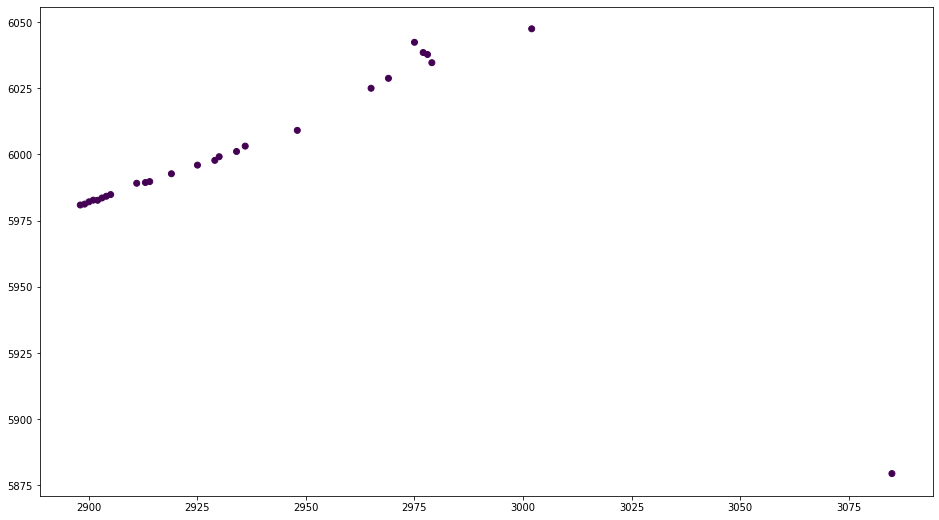

In [7]:
df_particle = get_particles(10)
get_particle_type(df_particle, 1)
df = get_graph(10)
df['type'] = df.apply(lambda x: get_particle_type(df_particle, x.true_id), axis=1)
df['process'] = df.apply(lambda x: get_process(df_particle, x.true_id), axis=1)
plt.figure(figsize=(16,9))
df_plane = df[(df.plane == 0) & (df.type == 11) & (df.process!=b'eIoni') & (df.process != b'compt') & (df.process != b'conv')]
print(df_plane)
plt.scatter(df_plane.wire, df_plane.time, c=df_plane.type)
plt.show()
plt.close()

In [352]:
df_particle[(df_particle.type==22)&(df_particle.end_process==b'conv')]

,end_process,end_x,end_y,end_z,event,id,momentum,parent_id,run,start_process,start_x,start_y,start_z,subrun,type
2,b'conv',-243.222,-114.179,1333.36,11,19,0.0138635,1,1,b'eBrem',-244.448,-113.381,1316.96,416,22
3,b'conv',-244.105,-113.606,1321.42,11,21,0.0414122,1,1,b'eBrem',-244.284,-113.489,1319.1,416,22
4,b'conv',-244.108,-113.604,1321.39,11,22,2.6637,1,1,b'eBrem',-244.251,-113.51,1319.53,416,22
6,b'conv',-243.769,-113.832,1325.94,11,24,0.396616,1,1,b'eBrem',-244.173,-113.562,1320.56,416,22
8,b'conv',-236.387,-119.021,1433.59,11,34,0.0198758,1,1,b'eBrem',-243.656,-113.9,1327.72,416,22
9,b'conv',-243.47,-114.028,1330.39,11,38,0.0329943,1,1,b'eBrem',-243.548,-113.976,1329.28,416,22
10,b'conv',-242.558,-114.638,1343.33,11,39,0.582685,1,1,b'eBrem',-243.531,-113.987,1329.52,416,22
11,b'conv',-239.668,-116.851,1383.84,11,42,0.0372203,1,1,b'eBrem',-243.419,-114.068,1331.11,416,22
12,b'conv',-242.772,-114.53,1340.07,11,43,0.0941689,1,1,b'eBrem',-243.408,-114.076,1331.27,416,22
14,b'conv',-260.285,-119.939,1428.97,11,46,0.00775172,1,1,b'eBrem',-243.283,-114.167,1332.95,416,22


In [343]:
df_particle[(abs(df_particle.type)==11)]

,end_process,end_x,end_y,end_z,event,id,momentum,parent_id,run,start_process,start_x,start_y,start_z,subrun,type
0,b'LArVoxelReadoutScoringProcess',-239.262,-117.805,1380.74,11,1,5.00055,0,1,b'primary',-244.52,-113.334,1316.02,416,11
26,b'LArVoxelReadoutScoringProcess',-239.314,-112.894,1385.96,11,118,0.0078953,95,1,b'compt',-239.649,-113.574,1384.69,416,11
27,b'LArVoxelReadoutScoringProcess',-246.352,-87.3167,1405.26,11,119,0.0026266,95,1,b'compt',-246.309,-87.9056,1405.03,416,11
28,b'LArVoxelReadoutScoringProcess',-241.981,-118.303,1420.13,11,140,0.00134915,91,1,b'compt',-241.957,-118.222,1420.02,416,11
29,b'LArVoxelReadoutScoringProcess',-237.659,-118.897,1372.66,11,161,0.00211766,84,1,b'compt',-237.844,-119.033,1372.35,416,11
30,b'LArVoxelReadoutScoringProcess',-240.849,-145.075,1403.46,11,163,0.00103439,84,1,b'compt',-240.847,-145.071,1403.46,416,11
31,b'LArVoxelReadoutScoringProcess',-235.391,-121.566,1398.45,11,168,0.0183372,82,1,b'conv',-235.206,-121.081,1391.74,416,11
32,b'annihil',-235.155,-123.294,1394.79,11,169,0.0102899,82,1,b'conv',-235.206,-121.081,1391.74,416,-11
34,b'LArVoxelReadoutScoringProcess',-235.912,-123.106,1423.42,11,176,0.00320028,173,1,b'compt',-236.087,-122.762,1422.83,416,11
35,b'LArVoxelReadoutScoringProcess',-241.337,-118.83,1360.76,11,219,0.0164051,72,1,b'conv',-240.574,-115.618,1359.23,416,11


#### Defining graph edges

The `create_edges` function constructs graph edges based on hit proximity. If two hits are within 5 wires and 50 time ticks of each other, an edge is produced which consists of a pair of indices pointing from one hit to the other.

In [8]:
def create_edges(df):
    edges = []
    for idx, node in df.iterrows():
        start = idx
        cut_wire = (df.wire - node.wire > 0) & (df.wire - node.wire <= 5)
        cut_time = (abs(df.time-node.time) < 50)
        end = df[cut_wire & cut_time].index[:]
        for e in end: edges.append((start, e))
    return np.array(edges).T

#### Making plots

This block of code loops over all events in the file, and over each wire plane within each event. It then constructs a number of plots:

1. Graph nodes (ie. hits), colour coded by the simulated particle that produced them.
2. The same node plot, with all potential graph edges drawn underneath in grey.
3. Graph edges only, with all **false** edges drawn in grey and all **true** edges drawn in black. A true edge is defined as an edge between two graph nodes that were produced by the same true particle.

In [15]:
import matplotlib.pyplot as plt
for evt in range(f['event_table']['event'].shape[0]):
#     if evt < 10: continue
#     elif evt > 10: break
#     print(f'Event {evt+1}, energy {nu_energy[evt].squeeze()}')
    df = get_graph(evt)
    df_part = get_particles(evt)
    print(df_part[(df_part.parent_id==0)])
    # Here we loop over all three wire planes and draw the particle interaction
    for plane in range(3):
        df_plane = df[(df.plane == plane)]
        # Node plot
        fig, ax = plt.subplots(figsize=[16,9])
        _ = plt.scatter(df_plane.wire, df_plane.time, c=df_plane.true_id)
        plt.tight_layout()
        plt.savefig(f'plots/evt{evt+1:03d}_plane{plane}_nodes.png')
        plt.close()
        
        # Node + edge plot
        edges = create_edges(df_plane)
        lines = [ [ [ df.wire[edge[0]], df.time[edge[0]] ], [ df.wire[edge[1]], df.time[edge[1]] ] ] for edge in edges.T ]
        fig, ax = plt.subplots(figsize=[16,9])
        lc = mc.LineCollection(lines, colors='gainsboro', linewidths=2, zorder=1)
        _ = plt.scatter(df_plane.wire, df_plane.time, c=df_plane.true_id, zorder=2)
        ax.add_collection(lc)
        ax.autoscale()
        plt.tight_layout()
        plt.savefig(f'plots/evt{evt+1:03d}_plane{plane}.png')
        plt.close()
        
        # Edge plot
        true_lines = []
        false_lines = []
        for l, e in zip(lines, edges.T):
            if df.true_id[e[0]] == df.true_id[e[1]]: true_lines.append(l)
            else: false_lines.append(l)
        lc_false = mc.LineCollection(false_lines, colors='gainsboro', linewidths=2, zorder=1)
        lc_true = mc.LineCollection(true_lines, colors='black', linewidths=2, zorder=1)
        fig, ax = plt.subplots(figsize=[16,9])
        ax.add_collection(lc_false)
        ax.add_collection(lc_true)
        ax.autoscale()
        plt.tight_layout()
        plt.savefig(f'plots/evt{evt+1:03d}_plane{plane}_edges.png')
        plt.close()

                        end_process    end_x    end_y    end_z event id  \
0  b'LArVoxelReadoutScoringProcess' -80.6836   499.22  602.344     1  1   
1               b'neutronInelastic' -107.451  454.379  550.994     1  2   
2  b'LArVoxelReadoutScoringProcess' -96.4107  517.209  539.513     1  3   

   momentum parent_id run start_process  start_x  start_y start_z subrun  type  
0   1.30832         0   1    b'primary' -94.8066  509.613  540.76    416    11  
1  0.195391         0   1    b'primary' -94.8066  509.613  540.76    416  2112  
2  0.444696         0   1    b'primary' -94.8066  509.613  540.76    416  2212  
                        end_process    end_x    end_y    end_z event id  \
0  b'LArVoxelReadoutScoringProcess' -294.394  414.886  1699.37     2  1   
1  b'LArVoxelReadoutScoringProcess' -305.029  403.763  1676.02     2  2   
2  b'LArVoxelReadoutScoringProcess' -297.507  398.575  1677.29     2  3   

   momentum parent_id run start_process  start_x  start_y  start_z subrun 

#### Clustering hits into subgraphs

This piece of code is designed to take locally connected sections of graph and aggregate them into larger subgraphs, which can then be used to construct a larger picture of the event. This is performed by assigning the first node an integer ID, and then following true edges to visit all connected nodes and assigning them the same ID until all connected nodes have been visited. The integer ID is then incremented, and the next node in the graph that has not already been visited is assigned with this second ID, and its neighbours are again visited. This process is repeated until all nodes have an ID.

After this procedure is complete, the hit graph has been divided into disconnected cluster-wise subgraphs. A new graph is then formed, with one node per cluster, aggregrating information from all the hits in that cluster, such as total integrated ADCs, average position and number of associated nodes.

The logic needs some refining – truth-matching true particles does not give sufficient reduction in number of nodes for an electromagnetic shower. Need to develop a scheme for clustering hits together more coarsely in this case.

In [324]:
def visit(idx, visited, counter, df, edges):
    if idx not in visited:
        df.at[idx, 'cluster'] = counter
        visited.add(idx)
        forward_edges = edges[1, (edges[0,:]==idx)]
        backward_edges = edges[0, (edges[1,:]==idx)]
        for edge in edges:
            if idx == edge[0]:
                if edge[1] not in visited:
                    visited, df, edges = visit(edge[1], visited, counter, df, edges)
            if idx == edge[1]:
                if edge[0] not in visited:
                    visited, df, edges = visit(edge[0], visited, counter, df, edges)
    return visited, df, edges

def cluster_graph(df, edges):
    
    df['cluster'] = -1
    visited = set()
    counter = 0
    for idx, row in df.iterrows():
        if idx in visited: continue
        visited, df, edges = visit(idx, visited, counter, df, edges)
        counter += 1
    wire = []
    time = []
    integral = []
    n_nodes = []
    for cluster in range(counter):
        nodes = df[(df.cluster == cluster)]
        n_nodes.append(nodes.shape[0])
        integral.append(nodes.integral.sum())
        wire.append(nodes.wire.mean())
        time.append(nodes.time.mean())
    return pd.DataFrame(np.array([wire, time, integral, n_nodes]).T, columns=['wire', 'time', 'integral', 'nodes'])

#### Drawing clusters

This loops over the views for one event and draws the cluster-wise graphs produced in the above code. This demonstrates that this part needs refining – ideally we would see fewer clusters in this stage.

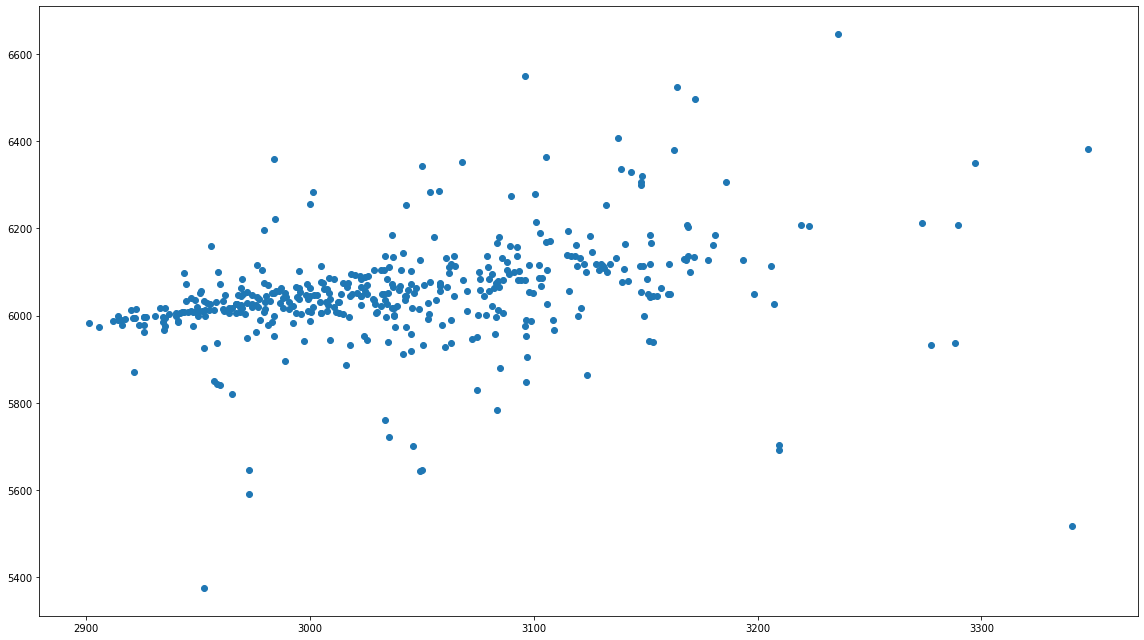

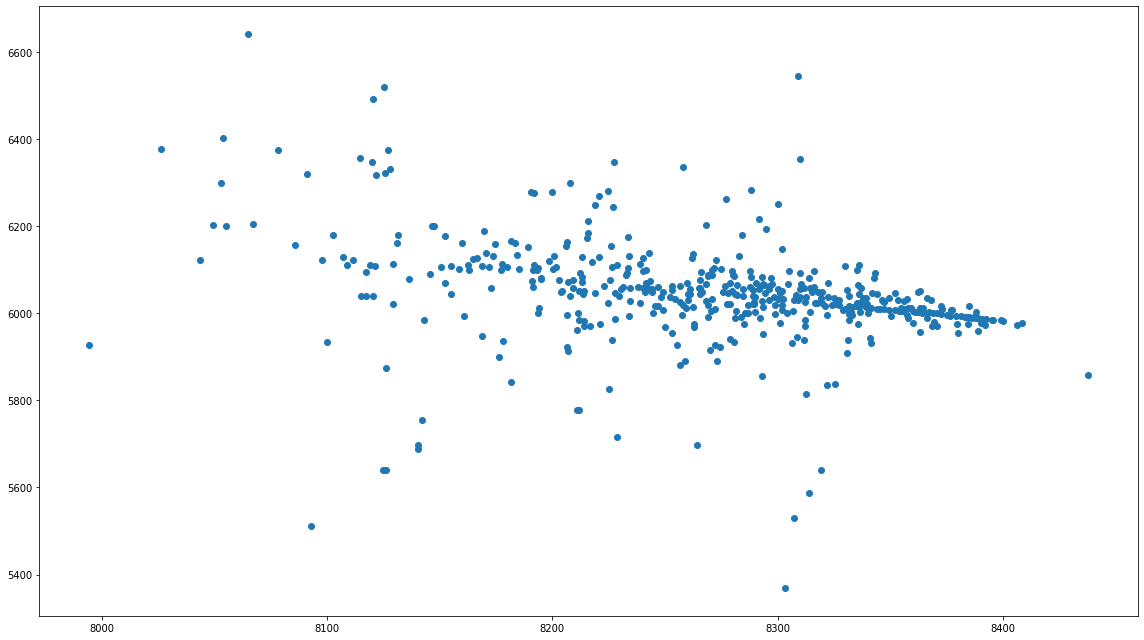

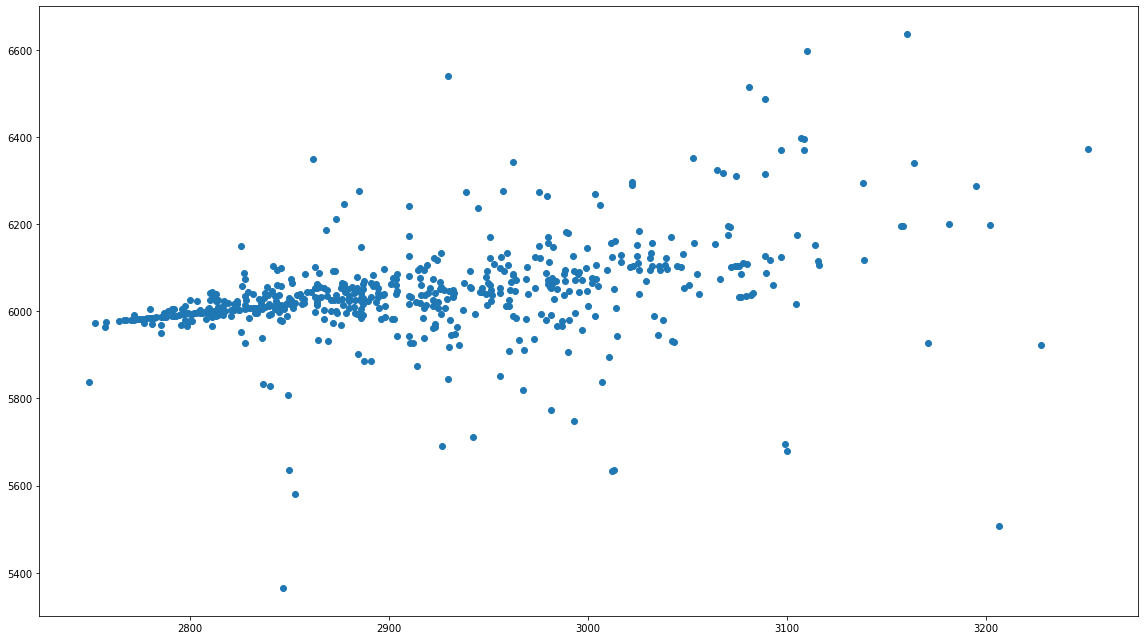

In [329]:
df = get_graph(10)
for plane in range(3):
    df_plane = df[(df.plane == plane)].reset_index()
    edges = create_edges(df_plane)
    true_edges = np.array([ edge for edge in edges.T if df_plane.true_id[edge[0]] == df_plane.true_id[edge[1]] ])
    df_cluster = cluster_graph(df_plane, true_edges)
    fig, ax = pl.subplots(figsize=[16,9])
    _ = plt.scatter(df_cluster.wire, df_cluster.time)
    plt.tight_layout()
    plt.savefig(f'plots/evt011_plane{plane}_clusters.png')
    plt.show()
    plt.close()

In [392]:
!ls /data/hit2d/fluxswap

gcnhit_002ff553-c67e-461d-99f8-1a700ecbc78c.h5
gcnhit_00425452-7074-4222-84c3-e94ba82b5909.h5
gcnhit_008ad911-a222-4cce-aef3-8b457d8a7d1d.h5
gcnhit_00a68c56-c70e-4229-a056-8cc7598e7d14.h5
gcnhit_028b3d2b-d05a-439c-9cb9-8978be98d1f4.h5
gcnhit_03094b55-5495-4d61-922e-28a333017cf5.h5
gcnhit_03842209-cbe8-4fdb-bc18-3e8b58f26b4e.h5
gcnhit_03cc62d6-cf24-4183-b5da-d465a8ff4f69.h5
gcnhit_04478e4d-662c-4266-9c79-d2a183ad8b64.h5
gcnhit_05ec2b8f-329d-415b-be81-d98e1d7b8bcd.h5
gcnhit_061e1238-3020-494f-83ba-0c7ed1c6b786.h5
gcnhit_0662bdf9-97e7-4990-a4bc-125cc7698cdc.h5
gcnhit_066799d6-9ff7-424c-ace5-fb2a936a9b42.h5
gcnhit_07327e10-f8fe-4de0-be8a-412a289c45fd.h5
gcnhit_07f9daf4-0c8c-4a2d-bc26-8328a9bd4ca4.h5
gcnhit_08d0e118-970e-459c-9840-87349245a9b4.h5
gcnhit_08daaaa1-d1f2-45ae-886c-f02075b27155.h5
gcnhit_09328037-79fc-4e62-af7f-6e6ff8504a42.h5
gcnhit_0a7da00b-b09d-432f-a3b5-23e03021d5f4.h5
gcnhit_0ad6b0cc-9e78-4c40-8be6-cdd7421ea498.h5
gcnhit_0b2c05dc-2ecc-43aa-8e04-653693688e89.h5
gcnhit_0b68b1